<a href="https://colab.research.google.com/github/alim98/Fusion-Project/blob/main/First_Working_3d_mri_brain_tumor_segmentation_u_net_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Brats official annotations](https://www.med.upenn.edu/cbica/assets/user-content/images/BraTS/brats-tumor-subregions.jpg)

# Setup env

In [1]:
!pip install nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 19.4 MB/s eta 0:00:00


In [2]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif
import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-pci0y0a6
  Running command git clone --filter=blob:none --quiet https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-pci0y0a6
  Resolved https://github.com/miykael/gif_your_nifti to commit 55c09c42921f4871cf43f63a303ab420a92a4f03
  Preparing metadata (setup.py) ... done
  Created wheel for gif-your-nifti: filename=gif_your_nifti-0.2.2-py3-none-any.whl size=6631 sha256=8663af1038577bc0bdc42fc80d014651265eee81c14f7b9c787ee3f57d2fb812
  Stored in directory: /tmp/pip-ephem-wheel-cache-ep3ycq65/wheels/3a/c2/0b/c08f2425925519bb014e107d2919dadc2556ec5e7c205e4472
Successfully built gif-your-nifti


In [3]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include

# Image data descriptions

All BraTS multimodal scans are available as  NIfTI files (.nii.gz) -> commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings
1. **T1**: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.
2. **T1c**: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.
3. **T2**: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.
4. **FLAIR**: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

Data were acquired with different clinical protocols and various scanners from multiple (n=19) institutions.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper. The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull-stripped.



In [4]:
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.16G/4.16G [00:37<00:00, 30.5MB/s]
100% 4.16G/4.16G [00:37<00:00, 118MB/s] 


In [5]:
!unzip /content/brats20-dataset-training-validation.zip

Archive:  /content/brats20-dataset-training-validation.zip
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_flair.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_seg.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_t1.n

# Setup env

In [ ]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif
import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-jrxwsrul
  Running command git clone --filter=blob:none --quiet https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-jrxwsrul
  Resolved https://github.com/miykael/gif_your_nifti to commit 55c09c42921f4871cf43f63a303ab420a92a4f03
  Preparing metadata (setup.py) ... done


In [ ]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include

# Image data descriptions

All BraTS multimodal scans are available as  NIfTI files (.nii.gz) -> commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings
1. **T1**: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.
2. **T1c**: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.
3. **T2**: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.
4. **FLAIR**: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

Data were acquired with different clinical protocols and various scanners from multiple (n=19) institutions.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper. The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull-stripped.



# Create model || U-Net: Convolutional Networks for Biomedical Image Segmentation
he u-net is convolutional network architecture for fast and precise segmentation of images. Up to now it has outperformed the prior best method (a sliding-window convolutional network) on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks. It has won the Grand Challenge for Computer-Automated Detection of Caries in Bitewing Radiography at ISBI 2015, and it has won the Cell Tracking Challenge at ISBI 2015 on the two most challenging transmitted light microscopy categories (Phase contrast and DIC microscopy) by a large margin
[more on](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)
![official definiton](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)


# Loss function
**Dice coefficient**
, which is essentially a measure of overlap between two samples. This measure ranges from 0 to 1 where a Dice coefficient of 1 denotes perfect and complete overlap. The Dice coefficient was originally developed for binary data, and can be calculated as:

![dice loss](https://wikimedia.org/api/rest_v1/media/math/render/svg/a80a97215e1afc0b222e604af1b2099dc9363d3b)

**As matrices**
![dice loss](https://www.jeremyjordan.me/content/images/2018/05/intersection-1.png)

[Implementation, (images above) and explanation can be found here](https://www.jeremyjordan.me/semantic-segmentation/)

In [7]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss



# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [8]:
IMG_SIZE=128

In [ ]:
# # source https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a

# def build_unet(inputs, ker_init, dropout):
#     conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
#     conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

#     pool = MaxPooling2D(pool_size=(2, 2))(conv1)
#     conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
#     conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
#     conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
#     conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
#     drop5 = Dropout(dropout)(conv5)

#     up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
#     merge7 = concatenate([conv3,up7], axis = 3)
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

#     up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
#     merge8 = concatenate([conv2,up8], axis = 3)
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

#     up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
#     merge9 = concatenate([conv,up9], axis = 3)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

#     up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
#     merge = concatenate([conv1,up], axis = 3)
#     conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
#     conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

#     conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

#     return Model(inputs = inputs, outputs = conv10)

# input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# model = build_unet(input_layer, 'he_normal', 0.2)
# model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

Proposed Model 2 (With Fusion)

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, ReLU, Add, Activation, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import he_normal

def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    shared_layer_one = tf.keras.layers.Dense(channel//ratio,
                                             activation='relu',
                                             kernel_initializer='he_normal',
                                             use_bias=True,
                                             bias_initializer='zeros')
    shared_layer_two = tf.keras.layers.Dense(channel,
                                             kernel_initializer='he_normal',
                                             use_bias=True,
                                             bias_initializer='zeros')

    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = tf.keras.layers.Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = tf.keras.layers.GlobalMaxPooling2D()(input_feature)
    max_pool = tf.keras.layers.Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = tf.keras.layers.Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    cbam_feature = tf.keras.layers.Conv2D(filters=1,
                                          kernel_size=kernel_size,
                                          strides=1,
                                          padding='same',
                                          activation='sigmoid',
                                          kernel_initializer='he_normal',
                                          use_bias=False)(input_feature)
    return Multiply()([input_feature, cbam_feature])

def residual_attention_block(input_feature, filters):
    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer=he_normal())(input_feature)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer=he_normal())(x)
    x = BatchNormalization()(x)

    # Channel attention
    x = channel_attention(x)
    # Spatial attention
    x = spatial_attention(x)

    # Adjust the input feature size to match the output feature size
    input_feature = Conv2D(filters, (1, 1), padding='same', kernel_initializer=he_normal())(input_feature)

    x = Add()([input_feature, x])
    x = ReLU()(x)
    return x

def multi_scale_feature_extraction(input_feature, filters):
    conv3x3 = Conv2D(filters, (3, 3), padding='same', kernel_initializer=he_normal(), activation='relu')(input_feature)
    conv5x5 = Conv2D(filters, (5, 5), padding='same', kernel_initializer=he_normal(), activation='relu')(input_feature)
    conv7x7 = Conv2D(filters, (7, 7), padding='same', kernel_initializer=he_normal(), activation='relu')(input_feature)
    return concatenate([conv3x3, conv5x5, conv7x7], axis=-1)

def cross_modality_feature_fusion(features):
    fused = concatenate(features, axis=-1)
    fused = Conv2D(fused.shape[-1], (1, 1), padding='same', kernel_initializer=he_normal(), activation='relu')(fused)
    return fused

def build_proposed_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Initial Convolutional Layers
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=he_normal())(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=he_normal())(conv1)

    # Multi-Scale Feature Extraction
    multi_scale_features = multi_scale_feature_extraction(conv1, 32)

    # Cross-Modality Feature Fusion
    fused_features = cross_modality_feature_fusion([conv1, multi_scale_features])

    pool1 = MaxPooling2D(pool_size=(2, 2))(fused_features)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=he_normal())(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=he_normal())(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=he_normal())(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=he_normal())(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=he_normal())(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=he_normal())(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=he_normal())(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=he_normal())(conv5)

    # Residual Attention Blocks
    rab = residual_attention_block(conv5, 512)

    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=he_normal())(UpSampling2D(size=(2, 2))(rab))
    merge6 = concatenate([conv4, up6], axis=3)
    rab6 = residual_attention_block(merge6, 256)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=he_normal())(UpSampling2D(size=(2, 2))(rab6))
    merge7 = concatenate([conv3, up7], axis=3)
    rab7 = residual_attention_block(merge7, 128)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=he_normal())(UpSampling2D(size=(2, 2))(rab7))
    merge8 = concatenate([conv2, up8], axis=3)
    rab8 = residual_attention_block(merge8, 64)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=he_normal())(UpSampling2D(size=(2, 2))(rab8))
    merge9 = concatenate([conv1, up9], axis=3)
    rab9 = residual_attention_block(merge9, 32)

    conv10 = Conv2D(num_classes, (1, 1), activation='softmax')(rab9)

    model = Model(inputs, conv10)

    return model

# Example usage
input_shape = (256, 256, 2) # Adjust according to your input shape
num_classes = 4
model = build_proposed_model(input_shape, num_classes)

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=num_classes)]
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 2)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         608       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d_1[0][0]']            
                                                                                              

# Proposed Model (worked without fusion)

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, ReLU, Add, Activation, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import he_normal

def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    shared_layer_one = tf.keras.layers.Dense(channel//ratio,
                                             activation='relu',
                                             kernel_initializer='he_normal',
                                             use_bias=True,
                                             bias_initializer='zeros')
    shared_layer_two = tf.keras.layers.Dense(channel,
                                             kernel_initializer='he_normal',
                                             use_bias=True,
                                             bias_initializer='zeros')

    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = tf.keras.layers.Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = tf.keras.layers.GlobalMaxPooling2D()(input_feature)
    max_pool = tf.keras.layers.Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = tf.keras.layers.Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    cbam_feature = tf.keras.layers.Conv2D(filters=1,
                                          kernel_size=kernel_size,
                                          strides=1,
                                          padding='same',
                                          activation='sigmoid',
                                          kernel_initializer='he_normal',
                                          use_bias=False)(input_feature)
    return Multiply()([input_feature, cbam_feature])

def residual_attention_block(input_feature, filters):
    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer=he_normal())(input_feature)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer=he_normal())(x)
    x = BatchNormalization()(x)

    # Channel attention
    x = channel_attention(x)
    # Spatial attention
    x = spatial_attention(x)

    # Adjust the input feature size to match the output feature size
    input_feature = Conv2D(filters, (1, 1), padding='same', kernel_initializer=he_normal())(input_feature)

    x = Add()([input_feature, x])
    x = ReLU()(x)
    return x

def build_proposed_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Initial Convolutional Layers
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=he_normal())(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=he_normal())(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=he_normal())(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=he_normal())(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=he_normal())(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=he_normal())(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=he_normal())(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=he_normal())(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=he_normal())(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=he_normal())(conv5)

    # Residual Attention Blocks
    rab = residual_attention_block(conv5, 512)

    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=he_normal())(UpSampling2D(size=(2, 2))(rab))
    merge6 = concatenate([conv4, up6], axis=3)
    rab6 = residual_attention_block(merge6, 256)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=he_normal())(UpSampling2D(size=(2, 2))(rab6))
    merge7 = concatenate([conv3, up7], axis=3)
    rab7 = residual_attention_block(merge7, 128)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=he_normal())(UpSampling2D(size=(2, 2))(rab7))
    merge8 = concatenate([conv2, up8], axis=3)
    rab8 = residual_attention_block(merge8, 64)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=he_normal())(UpSampling2D(size=(2, 2))(rab8))
    merge9 = concatenate([conv1, up9], axis=3)
    rab9 = residual_attention_block(merge9, 32)

    conv10 = Conv2D(num_classes, (1, 1), activation='softmax')(rab9)

    model = Model(inputs, conv10)

    return model

# Example usage
input_shape = (256, 256, 2) # Adjust according to your input shape
num_classes = 4
model = build_proposed_model(input_shape, num_classes)

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=num_classes)]
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 2)]        0         []                            
                                                                                                  
 conv2d_17 (Conv2D)          (None, 256, 256, 32)         608       ['input_2[0][0]']             
                                                                                                  
 conv2d_18 (Conv2D)          (None, 256, 256, 32)         9248      ['conv2d_17[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 32)         0         ['conv2d_18[0][0]']           
 g2D)                                                                                         

**model architecture** <br>
If you are about to use U-NET, I suggest to check out this awesome library that I found later, after manual implementation of U-NET [keras-unet-collection](https://pypi.org/project/keras-unet-collection/), which also contains implementation of dice loss, tversky loss and many more!

In [ ]:
!cp

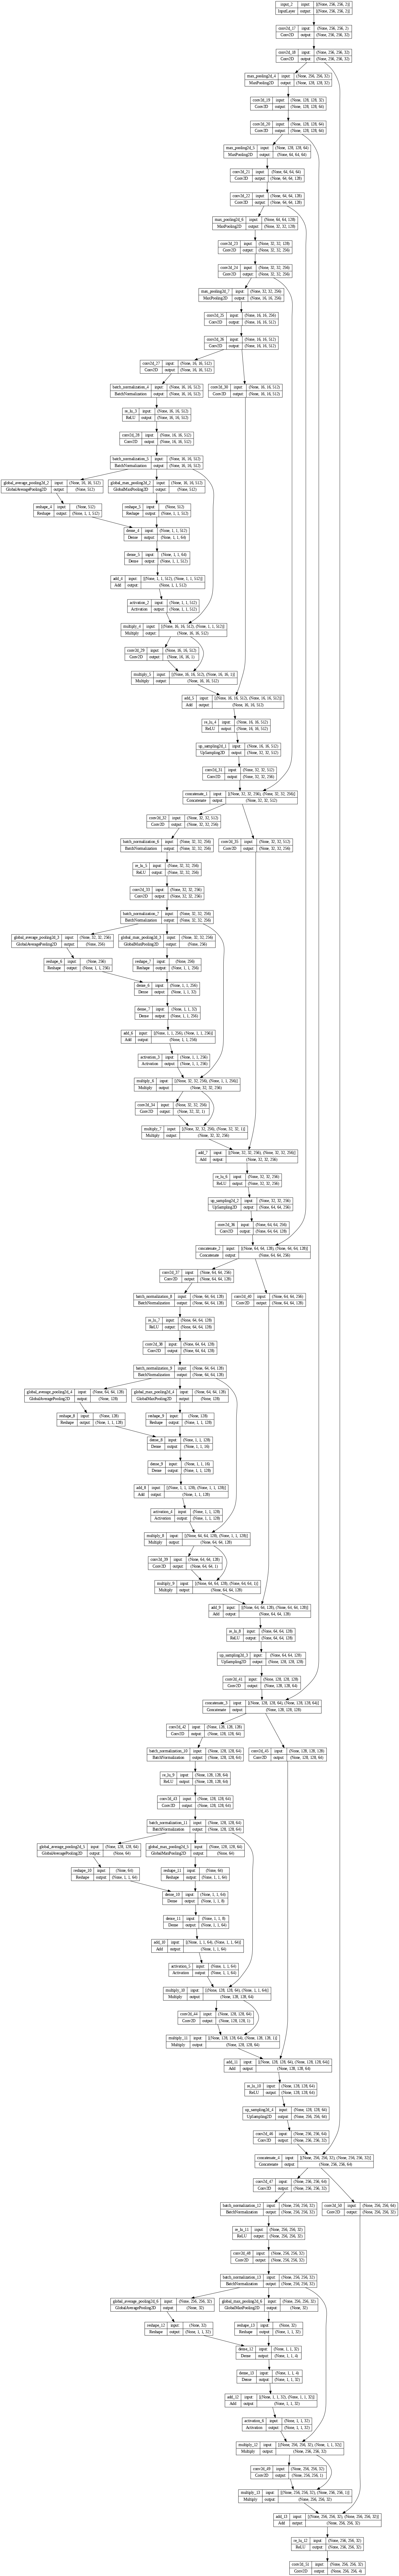

In [11]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

# Load data
Loading all data into memory is not a good idea since the data are too big to fit in.
So we will create dataGenerators - load data on the fly as explained [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [12]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

**Override Keras sequence DataGenerator class**

In [13]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

**Number of data used**
for training / testing / validation

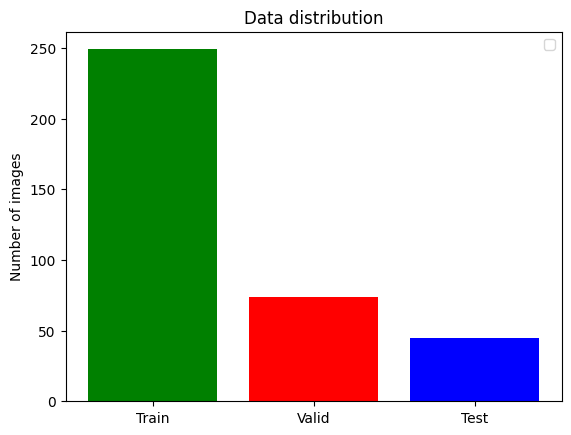

In [14]:
# show number of data for each dir
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()

showDataLayout()

**Add callback for training process**

In [15]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

# Train model
My best model was trained with 81% accuracy on mean IOU and 65.5% on Dice loss <br>
I will load this pretrained model instead of training again

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Input, BatchNormalization, GlobalAveragePooling2D, Dense, multiply, Add, Reshape
# from tensorflow.keras.models import Model

# def build_unet(inputs, ker_init, dropout):
#     # Initial Convolutional Layers
#     def initial_conv_block(input_tensor, filters):
#         conv = Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(input_tensor)
#         conv = BatchNormalization()(conv)
#         conv = Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv)
#         conv = BatchNormalization()(conv)
#         pool = MaxPooling2D(pool_size=(2, 2))(conv)
#         return conv, pool

#     conv1, pool1 = initial_conv_block(inputs, 32)
#     conv2, pool2 = initial_conv_block(pool1, 64)
#     conv3, pool3 = initial_conv_block(pool2, 128)
#     conv4, pool4 = initial_conv_block(pool3, 256)

#     # Feature Extraction and Fusion Block
#     def feature_extraction_block(input_tensor):
#         conv_3x3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(input_tensor)
#         conv_5x5 = Conv2D(128, (5, 5), activation='relu', padding='same', kernel_initializer=ker_init)(input_tensor)
#         conv_7x7 = Conv2D(128, (7, 7), activation='relu', padding='same', kernel_initializer=ker_init)(input_tensor)
#         merged = concatenate([conv_3x3, conv_5x5, conv_7x7], axis=3)
#         fused = Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer=ker_init)(merged)
#         return fused

#     fused = feature_extraction_block(pool4)

#     # Attention Mechanism
#     def channel_attention(input_tensor):
#         avg_pool = GlobalAveragePooling2D()(input_tensor)
#         dense1 = Dense(input_tensor.shape[-1] // 2, activation='relu')(avg_pool)
#         dense2 = Dense(input_tensor.shape[-1], activation='sigmoid')(dense1)
#         reshaped = Reshape((1, 1, input_tensor.shape[-1]))(dense2)
#         scaled = multiply([input_tensor, reshaped])
#         return scaled

#     def spatial_attention(input_tensor):
#         conv = Conv2D(input_tensor.shape[-1], (7, 7), activation='sigmoid', padding='same', kernel_initializer=ker_init)(input_tensor)
#         scaled = multiply([input_tensor, conv])
#         return scaled

#     att_channel = channel_attention(fused)
#     att_spatial = spatial_attention(fused)
#     att_combined = Add()([att_channel, att_spatial])

#     # Residual Attention Blocks
#     def residual_attention_block(input_tensor, filters):
#         conv = Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(input_tensor)
#         conv = BatchNormalization()(conv)
#         conv = Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv)
#         conv = BatchNormalization()(conv)
#         att_channel = channel_attention(conv)
#         att_spatial = spatial_attention(conv)
#         att_combined = Add()([att_channel, att_spatial])
#         residual = Conv2D(filters, (1, 1), activation='linear', padding='same', kernel_initializer=ker_init)(input_tensor)
#         output = Add()([residual, att_combined])
#         return output

#     rab1 = residual_attention_block(att_combined, 128)
#     rab2 = residual_attention_block(rab1, 128)
#     rab3 = residual_attention_block(rab2, 128)

#     # Intermediate Fusion Blocks
#     def intermediate_fusion_block(skip_tensor, input_tensor, filters, upsample_size):
#         upsampled = UpSampling2D(size=upsample_size)(input_tensor)
#         merged = concatenate([skip_tensor, upsampled], axis=3)
#         conv = Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(merged)
#         conv = BatchNormalization()(conv)
#         return conv

#     fusion1 = intermediate_fusion_block(conv4, rab3, 256, (2, 2))
#     fusion2 = intermediate_fusion_block(conv3, fusion1, 128, (2, 2))
#     fusion3 = intermediate_fusion_block(conv2, fusion2, 64, (2, 2))

#     # Upsampling and Refinement Block
#     def upsample_block(input_tensor, filters):
#         up = UpSampling2D(size=(2, 2))(input_tensor)
#         up = Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(up)
#         up = BatchNormalization()(up)
#         return up

#     up1 = upsample_block(fusion3, 64)
#     up2 = upsample_block(up1, 32)

#     # Final Convolutional Layer
#     final_conv = Conv2D(4, (1, 1), activation='softmax')(up2)

#     return Model(inputs=inputs, outputs=final_conv)

# input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
# model = build_unet(input_layer, 'he_normal', 0.2)
# model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4)])

# model.summary()


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Input, BatchNormalization, GlobalAveragePooling2D, Dense, multiply, Add, Reshape
# from tensorflow.keras.models import Model

# def build_unet(inputs, ker_init, dropout):
#     # Initial Convolutional Layers
#     def initial_conv_block(input_tensor, filters):
#         conv = Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(input_tensor)
#         conv = BatchNormalization()(conv)
#         conv = Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv)
#         conv = BatchNormalization()(conv)
#         pool = MaxPooling2D(pool_size=(2, 2))(conv)
#         return conv, pool

#     conv1, pool1 = initial_conv_block(inputs, 32)
#     conv2, pool2 = initial_conv_block(pool1, 64)
#     conv3, pool3 = initial_conv_block(pool2, 128)
#     conv4, pool4 = initial_conv_block(pool3, 256)

#     # Feature Extraction and Fusion Block
#     def feature_extraction_block(input_tensor):
#         conv_3x3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(input_tensor)
#         conv_5x5 = Conv2D(128, (5, 5), activation='relu', padding='same', kernel_initializer=ker_init)(input_tensor)
#         conv_7x7 = Conv2D(128, (7, 7), activation='relu', padding='same', kernel_initializer=ker_init)(input_tensor)
#         merged = concatenate([conv_3x3, conv_5x5, conv_7x7], axis=3)
#         fused = Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer=ker_init)(merged)
#         return fused

#     fused = feature_extraction_block(pool4)

#     # Attention Mechanism
#     def channel_attention(input_tensor):
#         avg_pool = GlobalAveragePooling2D()(input_tensor)
#         dense1 = Dense(input_tensor.shape[-1] // 2, activation='relu')(avg_pool)
#         dense2 = Dense(input_tensor.shape[-1], activation='sigmoid')(dense1)
#         reshaped = Reshape((1, 1, input_tensor.shape[-1]))(dense2)
#         scaled = multiply([input_tensor, reshaped])
#         return scaled

#     def spatial_attention(input_tensor):
#         conv = Conv2D(input_tensor.shape[-1], (7, 7), activation='sigmoid', padding='same', kernel_initializer=ker_init)(input_tensor)
#         scaled = multiply([input_tensor, conv])
#         return scaled

#     att_channel = channel_attention(fused)
#     att_spatial = spatial_attention(fused)
#     att_combined = Add()([att_channel, att_spatial])

#     # Residual Attention Blocks
#     def residual_attention_block(input_tensor, filters):
#         conv = Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(input_tensor)
#         conv = BatchNormalization()(conv)
#         conv = Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv)
#         conv = BatchNormalization()(conv)
#         att_channel = channel_attention(conv)
#         att_spatial = spatial_attention(conv)
#         att_combined = Add()([att_channel, att_spatial])
#         residual = Conv2D(filters, (1, 1), activation='linear', padding='same', kernel_initializer=ker_init)(input_tensor)
#         output = Add()([residual, att_combined])
#         return output

#     rab1 = residual_attention_block(att_combined, 128)
#     rab2 = residual_attention_block(rab1, 128)
#     rab3 = residual_attention_block(rab2, 128)

#     # Intermediate Fusion Blocks
#     def intermediate_fusion_block(skip_tensor, input_tensor, filters, upsample_size):
#         upsampled = UpSampling2D(size=upsample_size)(input_tensor)
#         merged = concatenate([skip_tensor, upsampled], axis=3)
#         conv = Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(merged)
#         conv = BatchNormalization()(conv)
#         return conv

#     fusion1 = intermediate_fusion_block(conv4, rab3, 256, (2, 2))
#     fusion2 = intermediate_fusion_block(conv3, fusion1, 128, (2, 2))
#     fusion3 = intermediate_fusion_block(conv2, fusion2, 64, (2, 2))

#     # Upsampling and Refinement Block
#     def upsample_block(input_tensor, filters):
#         up = UpSampling2D(size=(2, 2))(input_tensor)
#         up = Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(up)
#         up = BatchNormalization()(up)
#         return up

#     up1 = upsample_block(fusion3, 64)
#     up2 = upsample_block(up1, 32)

#     # Final Convolutional Layer
#     final_conv = Conv2D(4, (1, 1), activation='softmax')(up2)

#     return Model(inputs=inputs, outputs=final_conv)

# input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
# model = build_unet(input_layer, 'he_normal', 0.2)
# model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4)])

# model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 2)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         608       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['batch_normalization[0][0

In [18]:
K.clear_session()
from tensorflow.keras.preprocessing.image import ImageDataGenerator


history =  model.fit(training_generator,
                    epochs=35,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )
model.save("model_x1_1.h5")

Epoch 1/35
249/249 [==============================] - 385s 1s/step - loss: 0.0944 - accuracy: 0.9760 - mean_io_u: 0.3844 - val_loss: 0.1038 - val_accuracy: 0.9644 - val_mean_io_u: 0.3755 - lr: 0.0010
Epoch 2/35
249/249 [==============================] - 338s 1s/step - loss: 0.0458 - accuracy: 0.9863 - mean_io_u: 0.3888 - val_loss: 0.1091 - val_accuracy: 0.9706 - val_mean_io_u: 0.3755 - lr: 0.0010
Epoch 3/35
249/249 [==============================] - 341s 1s/step - loss: 0.0468 - accuracy: 0.9860 - mean_io_u: 0.4063 - val_loss: 0.0823 - val_accuracy: 0.9796 - val_mean_io_u: 0.3755 - lr: 0.0010
Epoch 4/35
249/249 [==============================] - 337s 1s/step - loss: 0.0457 - accuracy: 0.9863 - mean_io_u: 0.4100 - val_loss: 0.1285 - val_accuracy: 0.9608 - val_mean_io_u: 0.3860 - lr: 0.0010
Epoch 5/35
249/249 [==============================] - ETA: 0s - loss: 0.0409 - accuracy: 0.9869 - mean_io_u: 0.4021
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
249/249

KeyboardInterrupt: 

In [19]:
model.save("model_x1_1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
# K.clear_session()
# from tensorflow.keras.preprocessing.image import ImageDataGenerator


# history =  model.fit(training_generator,
#                     epochs=35,
#                     steps_per_epoch=len(train_ids),
#                     callbacks= callbacks,
#                     validation_data = valid_generator
#                     )
# model.save("model_x1_1.h5")

Epoch 1/35
249/249 [==============================] - 321s 1s/step - loss: 0.0815 - accuracy: 0.9812 - mean_io_u: 0.3779 - val_loss: 0.4034 - val_accuracy: 0.8546 - val_mean_io_u: 0.3755 - lr: 0.0010
Epoch 2/35
249/249 [==============================] - 255s 1s/step - loss: 0.0447 - accuracy: 0.9858 - mean_io_u: 0.3948 - val_loss: 0.1168 - val_accuracy: 0.9625 - val_mean_io_u: 0.3755 - lr: 0.0010
Epoch 3/35
249/249 [==============================] - 255s 1s/step - loss: 0.0412 - accuracy: 0.9868 - mean_io_u: 0.3858 - val_loss: 0.1192 - val_accuracy: 0.9609 - val_mean_io_u: 0.3755 - lr: 0.0010
Epoch 4/35
249/249 [==============================] - 256s 1s/step - loss: 0.0379 - accuracy: 0.9876 - mean_io_u: 0.3938 - val_loss: 0.1133 - val_accuracy: 0.9679 - val_mean_io_u: 0.3755 - lr: 0.0010
Epoch 5/35
249/249 [==============================] - 258s 1s/step - loss: 0.0378 - accuracy: 0.9878 - mean_io_u: 0.3804 - val_loss: 0.1933 - val_accuracy: 0.9393 - val_mean_io_u: 0.3755 - lr: 0.0010


KeyboardInterrupt: 

**Visualize the training process**

ValueError: x and y must have same first dimension, but have shapes (1,) and (5,)

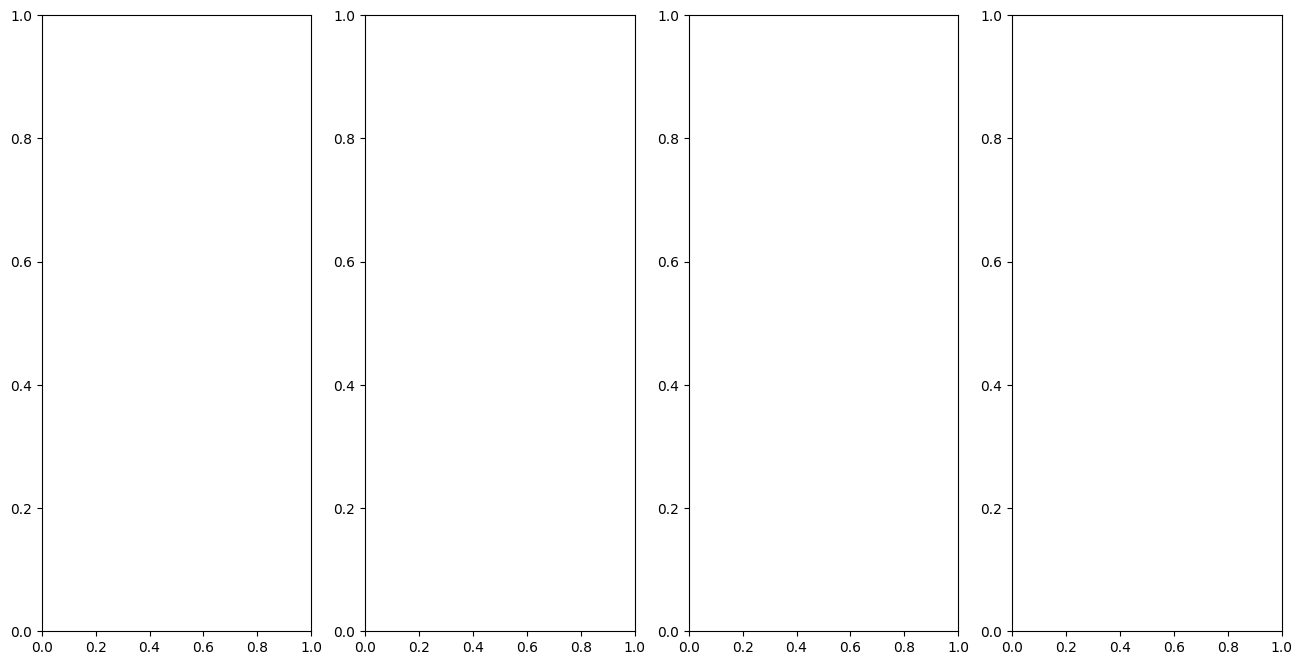

In [23]:
############ load trained model ################
model = keras.models.load_model('/content/model_x1_1.h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('/content/training.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=25

loss=hist['loss']
val_loss=hist['val_loss']

# train_dice=hist['dice_coef']
# val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

# ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
# ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
# ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

# Prediction examples

In [24]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)


In [28]:
IMG_SIZE=256

4/4 [==============================] - 30s 2s/step


<Figure size 1800x5000 with 0 Axes>

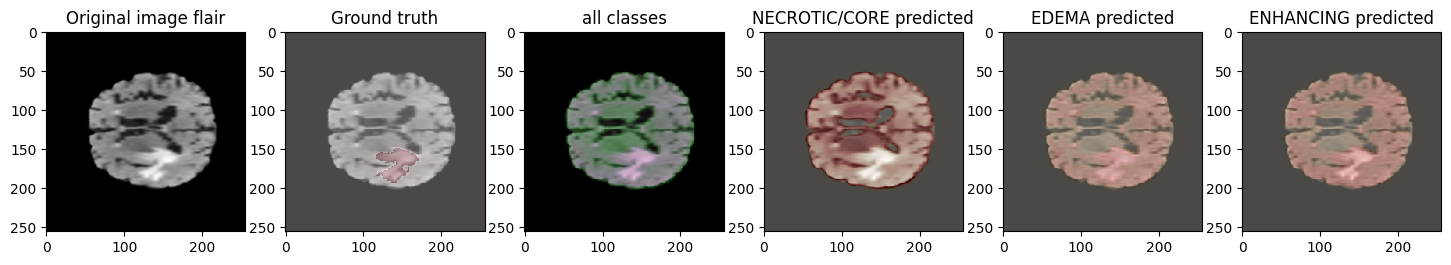

4/4 [==============================] - 1s 274ms/step


<Figure size 1800x5000 with 0 Axes>

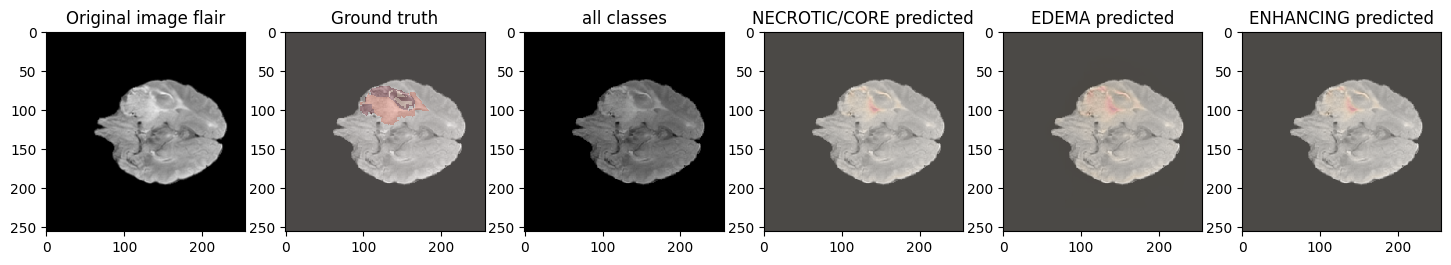

4/4 [==============================] - 1s 273ms/step


<Figure size 1800x5000 with 0 Axes>

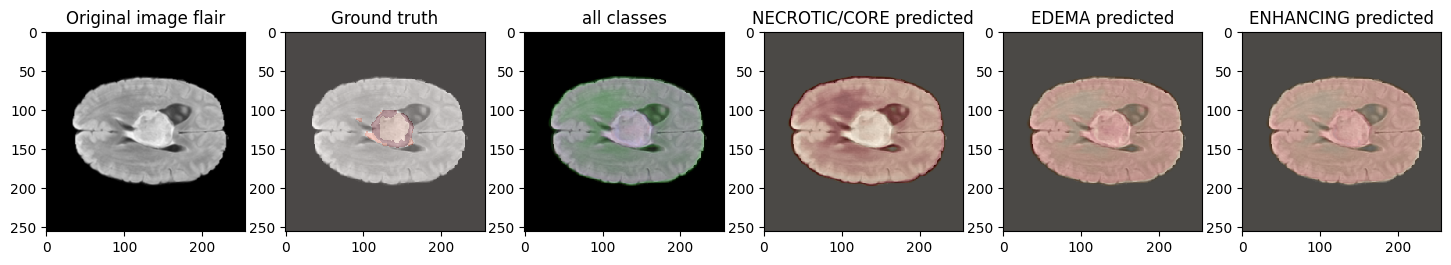

4/4 [==============================] - 1s 274ms/step


<Figure size 1800x5000 with 0 Axes>

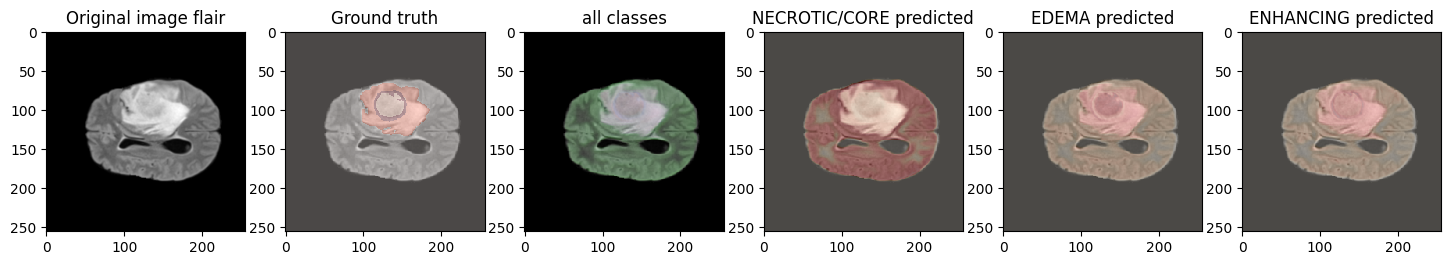

4/4 [==============================] - 1s 274ms/step


<Figure size 1800x5000 with 0 Axes>

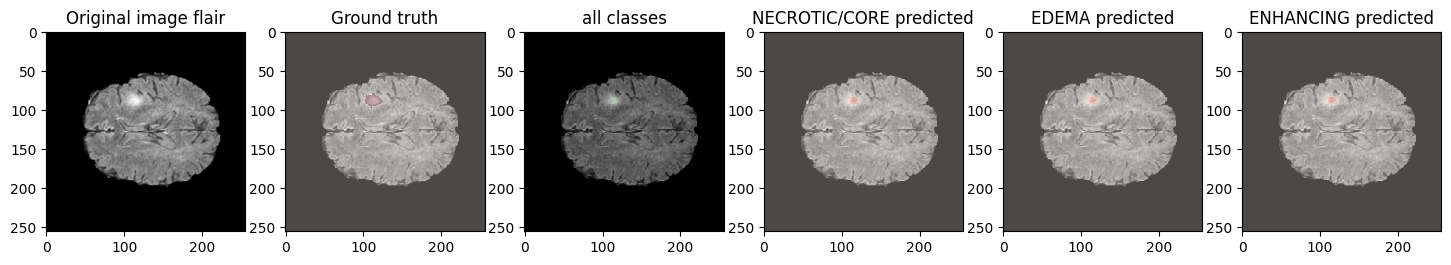

4/4 [==============================] - 1s 277ms/step


<Figure size 1800x5000 with 0 Axes>

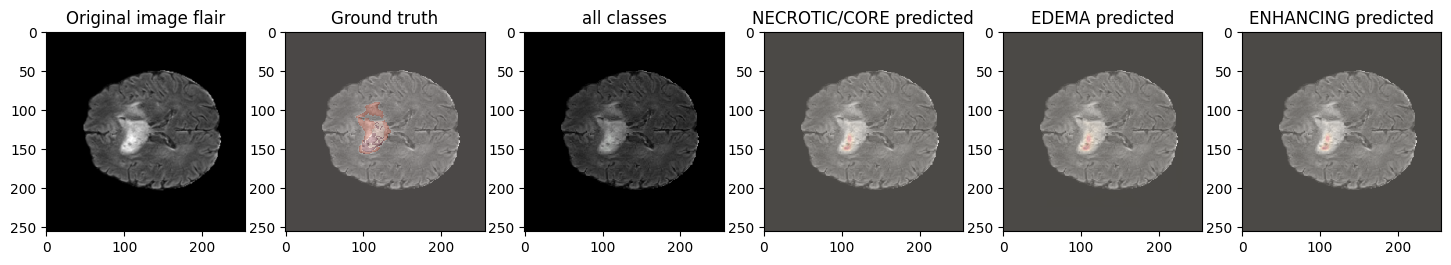

4/4 [==============================] - 1s 277ms/step


<Figure size 1800x5000 with 0 Axes>

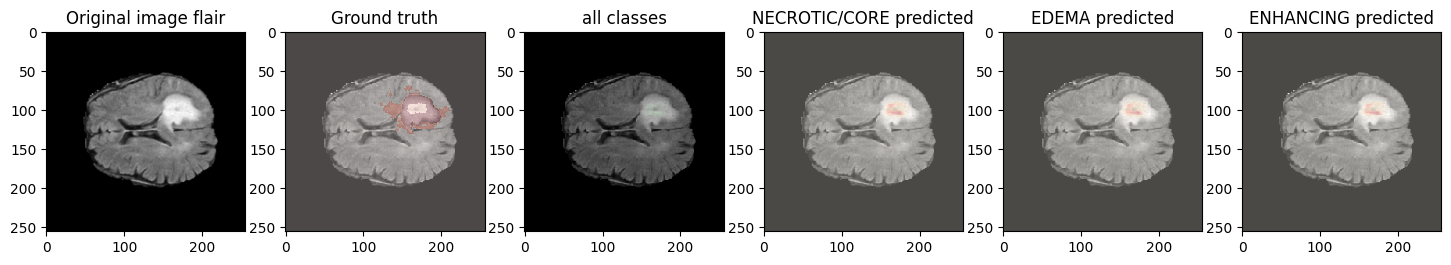

In [29]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()

 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()


showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])


# mask = np.zeros((10,10))
# mask[3:-3, 3:-3] = 1 # white square in black background
# im = mask + np.random.randn(10,10) * 0.01 # random image
# masked = np.ma.masked_where(mask == 0, mask)

# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(im, 'gray', interpolation='none')
# plt.subplot(1,2,2)
# plt.imshow(im, 'gray', interpolation='none')
# plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
# plt.show()

# Evaluation

4/4 [==============================] - 1s 280ms/step


<Figure size 640x480 with 0 Axes>

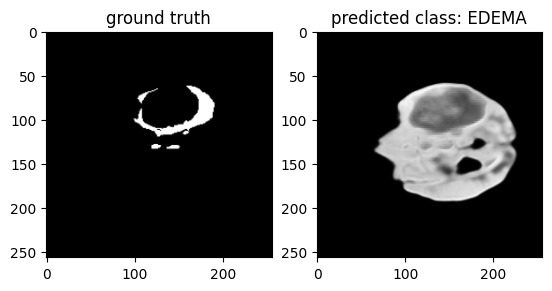

In [30]:
case = case=test_ids[3][-3:]
path = f"BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



gt[gt != eval_class] = 1 # use only one class for per class evaluation

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [31]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data


ValueError: could not broadcast input array from shape (256,256) into shape (128,128)

# Survival prediction

Full implementation can be found in my another notebook: https://www.kaggle.com/rastislav/mri-brain-tumor-survival-prediction